## Описание проекта

Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. **Задача — обучить на этих данных модель для прогноза оттока клиентов.**

**Описание услуг**

Оператор предоставляет два основных типа услуг:
- Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- Интернет. Подключение бывает двух типов: через телефонную линию DSL (от англ. digital subscriber line — «цифровая абонентская линия») или оптоволоконный кабель (англ. fiber optic).

Также абонентам доступен ряд услуг:
- Интернет-безопасность: антивирус (Device Protection) и блокировка опасных сайтов (Online Security);
- Выделенная линия технической поддержки (Tech Support);
- Облачное хранилище файлов для резервного копирования данных (Online Backup);
- Стриминговое телевидение (Streaming TV) и каталог фильмов (Streaming Movies).

За услуги клиенты могут платить ежемесячно или раз в 1–2 года. Доступны различные способы расчёта и возможность получить электронный чек.

**Описание данных**

Данные хранятся в базе данных PostgreSQL. Она состоит из нескольких таблиц:
- contract — информация о договорах;
- personal — персональные данные клиентов;
- internet — информация об интернет-услугах;
- phone — информация об услугах телефонии.

Таблица telecom.contract
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента.

Таблица personal
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети.

Таблица telecom.internet
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов.

Таблица telecom.phone
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

## Импорты, функции и константы

In [1]:
# Импортиуем необходимые библиотеки

import warnings
import time
from tqdm import tqdm
from tqdm import notebook
tqdm.pandas()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#!pip install phik
import phik
from phik.report import plot_correlation_matrix
from phik import report

from sqlalchemy import create_engine

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve, confusion_matrix, accuracy_score, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier
#!pip install lightgbm
from lightgbm import LGBMClassifier
#!pip install xgboost
import xgboost


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [2]:
# Необходимые функции

def df_info(df):
    
    print(f'Информация о DF {df.name}')
    print()
    display(df.head(7))
    print()
    print(df.info(memory_usage = 'deep'))
    print()
    display(df.describe())
    
    
def nan_plot(data):

    '''Визуализация NaN значений в таблице'''
    
    nan_dict = {}
    for column in data:
        nan_dict[column] = data[column].isna().sum() / data.shape[0]

    df_nan = pd.DataFrame(data=list(nan_dict.values()),
                          index=list(nan_dict.keys()),
                          columns=['Процент пропущенных значений'])


    ### Построим barplot с NaN значениями
    plt.figure(figsize=(25,13))

    plots = sns.barplot(data=df_nan,
                        x=list(df_nan.index),
                        y = 'Процент пропущенных значений',
                        palette = 'coolwarm')
    plt.title(f'Процент и количество пропущенных значений в {data.name}', fontsize=18)

    ### Поставим annot
    i = 0
    for bar in plots.patches:
        plots.annotate([format(bar.get_height(), '.1%'), data[data.columns[i]].isna().sum()],
                       (bar.get_x() + bar.get_width() / 2,
                        bar.get_height()), ha='center', va='center',
                       size=10, xytext=(0, 8),
                       textcoords='offset points')
        i += 1
        
def data_spread(df, column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
    
    df.boxplot(column=column, ax=ax[0])
    ax[0].set_title(f'Диаграмма размаха на столбце {column}')
    ax[0].grid(True)

    ax[1].hist(df[column], bins=200)
    ax[1].set_title(f'Гистограмма на столбце {column}')
    ax[1].grid(True)

    fig.suptitle(f'Разброс данных столбца {column}')

    plt.show()
    print('    ', '-'*104)
        
def uniqueness(df, column_list):
    
    '''Просмотр уникальных значений листа'''
    
    for column in column_list:
        print(f'Количество уникальных значений столбца {column}: {df[column].nunique()}')
        print(df[column].unique())
        print('-----------------------------')
        
def upsampling(features, target, repeat):
    '''Увеличение выборки. Техника upsampling. Вначале возвращает особенности, а затем target'''
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] +  [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [3]:
# Задаём константы

RANDOM_STATE = 10523

## Распаковка данных

In [4]:
# Подключимся к БД


db_config = {
            'user': 'praktikum_student', # Имя пользователя
            'pwd': 'Sdf4$2;d-d30pp', # Пароль
            'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', # Хост
            'port': 6432, # Порт подключения
            'db': 'data-science-final' # Название базы данных,
            }

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
) 

engine = create_engine(connection_string)

Информация о DF contract



,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
2,3668-QPYBK,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
4,9237-HQITU,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65
5,9305-CDSKC,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           1869 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(6)
memory usage: 2.4 MB
None



,MonthlyCharges,TotalCharges
count,7043.000000,7032.000000
mean,64.761692,2283.300441
std,30.090047,2266.771362
min,18.250000,18.800000
25%,35.500000,401.450000
50%,70.350000,1397.475000
75%,89.850000,3794.737500
max,118.750000,8684.800000


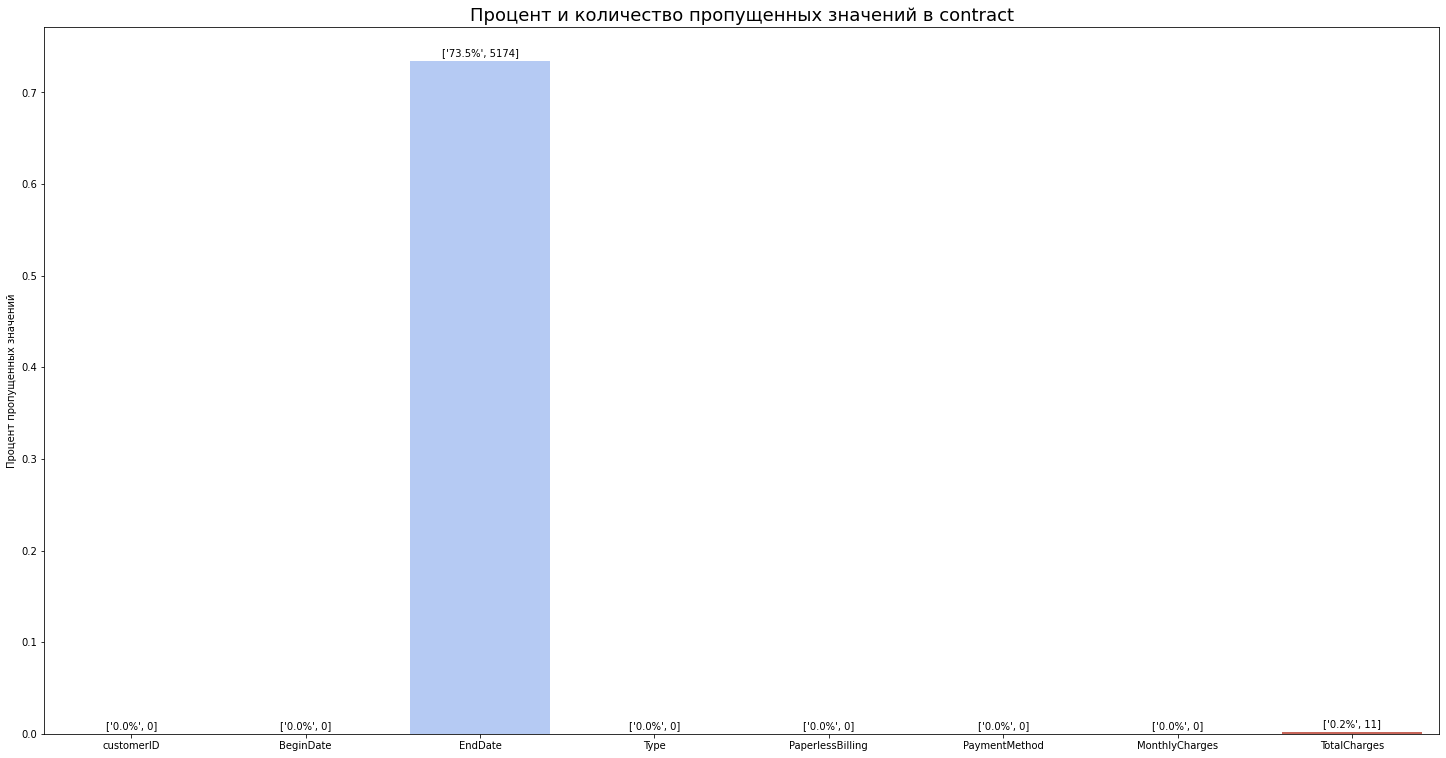

In [5]:
# Распакуем каждую из сущностей в наши таблицы

contract = '''
SELECT *
FROM telecom.contract
'''
contract = pd.read_sql_query(contract, con = engine)
contract.name = 'contract'

df_info(contract)
nan_plot(contract)

In [6]:
# Самый "старый" пользователь
contract['BeginDate'].min()

datetime.date(2018, 4, 17)

In [7]:
warnings.filterwarnings('ignore')

display(contract.loc[contract.TotalCharges.isna()])
print()
print('Верно ли утверждение, что данные из столбца TotalCharges равны NaN в том случае, если человек стал пользователем компании в deadline сбора данных (1 февраля 2022 года):',
     (contract.loc[contract.TotalCharges.isna()].index == contract.loc[contract['BeginDate'] == pd.Timestamp('2020-02-01')].index).all())

warnings.filterwarnings('default')

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN
1,3115-CZMZD,2020-02-01,None,Two year,No,Mailed check,20.25,NaN
3,5709-LVOEQ,2020-02-01,None,Two year,No,Mailed check,80.85,NaN
6,4367-NUYAO,2020-02-01,None,Two year,No,Mailed check,25.75,NaN
7,1371-DWPAZ,2020-02-01,None,Two year,No,Credit card (automatic),56.05,NaN
9,3213-VVOLG,2020-02-01,None,Two year,No,Mailed check,25.35,NaN
10,2923-ARZLG,2020-02-01,None,One year,Yes,Mailed check,19.70,NaN
11,2775-SEFEE,2020-02-01,None,Two year,Yes,Bank transfer (automatic),61.90,NaN
4408,7644-OMVMY,2020-02-01,None,Two year,No,Mailed check,19.85,NaN
5160,2520-SGTTA,2020-02-01,None,Two year,No,Mailed check,20.00,NaN



Верно ли утверждение, что данные из столбца TotalCharges равны NaN в том случае, если человек стал пользователем компании в deadline сбора данных (1 февраля 2022 года): True


In [8]:
personal = '''
SELECT *
FROM telecom.personal
'''
personal = pd.read_sql_query(personal, con = engine)
personal.name = 'personal'

df_info(personal)

Информация о DF personal



,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
5,9305-CDSKC,Female,0,No,No
6,1452-KIOVK,Male,0,No,Yes



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 1.7 MB
None



,SeniorCitizen
count,7043.000000
mean,0.162147
std,0.368612
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
internet = '''
SELECT *
FROM telecom.internet
'''
internet = pd.read_sql_query(internet, con = engine)
internet_columns = internet.iloc[0]
internet = internet[1:]
internet.columns = internet_columns
internet.name = 'internet'

df_info(internet)

Информация о DF internet



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No
2,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
4,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
5,9237-HQITU,Fiber optic,No,No,No,No,No,No
6,9305-CDSKC,Fiber optic,No,No,Yes,No,Yes,Yes
7,1452-KIOVK,Fiber optic,No,Yes,No,No,Yes,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 1 to 5517
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 2.6 MB
None



,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517,5517
unique,5517,2,2,2,2,2,2,2
top,9286-DOJGF,Fiber optic,No,No,No,No,No,No
freq,1,3096,3498,3088,3095,3473,2810,2785


In [10]:
phone = '''
SELECT *
FROM telecom.phone
'''
phone = pd.read_sql_query(phone, con = engine)
phone_columns = phone.iloc[0]
phone = phone[1:]
phone.columns = phone_columns
phone.name = 'phone'

df_info(phone)

Информация о DF phone



,customerID,MultipleLines
1,5575-GNVDE,No
2,3668-QPYBK,No
3,9237-HQITU,No
4,9305-CDSKC,Yes
5,1452-KIOVK,Yes
6,7892-POOKP,Yes
7,6388-TABGU,No



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 1 to 6361
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 785.7 KB
None



,customerID,MultipleLines
count,6361,6361
unique,6361,2
top,1000-AJSLD,No
freq,1,3390


In [11]:
for dataset in [personal, internet, phone]:
    print(f'Количество уникальных ID клиентов в множестве contract и {dataset.name} =',
          len(set(contract['customerID']) & set(dataset['customerID'])))

print()
print(f'Количество уникальных ID клиентов в множестве phone и internet =',
          len(set(phone['customerID']) & set(internet['customerID'])))

Количество уникальных ID клиентов в множестве contract и personal = 7043
Количество уникальных ID клиентов в множестве contract и internet = 5517
Количество уникальных ID клиентов в множестве contract и phone = 6361

Количество уникальных ID клиентов в множестве phone и internet = 4835


### Вывод

Нам удалось установить связь с базой данных и вытащить из неё 4 таблицы:
- contract — информация о договорах. Всего наблюдений по контрактам у нас 7043, а также 8 фичей. В данном DF 73,5% пропущенных значений в признаке EndDate (дата окончания действия договора) - это пользователи, которые не разорвали контракт, наш будущий класс 0. А также 11 NaN значений в столбце TotalCharges (общие расходы абонента), данные пропущенные значения связаны лишь с теми людьми, которые сформировали договор с «ТелеДом» в последний день сбора данных ("Информация о договорах актуальна на 1 февраля 2020"), поэтому никакой полезной информации, к сожалению, они нам не предоставят, и мы их удалим. Наименования столбцов в порядке, однако необходимо поменять тип данных столбцов BeginDate и EndDate -> datetime[64].
- personal — персональные данные клиентов. В данном DF также 7043, что очевидно (1 пользователь - 1 контракт), и 5 столбцов. В дальнейшем необходимо изменить данные в столбце SeniorCitizen (является ли абонент пенсионером) int -> object.
- internet — информация об интернет-услугах. Всего 5517 наблюдений и 8 признаков. Пропущенных значений нет, наименования столбцов в норме.
- phone — информация об услугах телефонии. Он предоставляет нам 6361 наблюдение и всего 2 столбца.

Для дальнейшей работы необходимо понять один момент: пересечение множества значений customerID из столбца internet и phone даст нам 4835 значений - клиенты, которые пользуются и интернетом, и телефонной связью вместе. Это означает, что не все пользователи пользуются и тем, и тем сразу же. Пересечение contract и internet даст нам 5517 значений, а contract и phone - 6361 значение. Нужно понимать, что при дальнейшем объединении всех 4 таблиц нужно будет заполнять NaN значения определённым типом "Без интернета" или "Без телефонной связи".

## Предобработка (знакомство и объединение)

#### DF contract

In [12]:
contract.head(1)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,4472-LVYGI,2020-02-01,None,Two year,Yes,Bank transfer (automatic),52.55,NaN


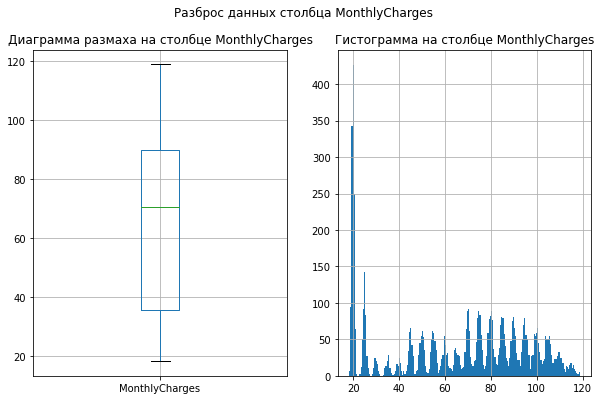

     --------------------------------------------------------------------------------------------------------


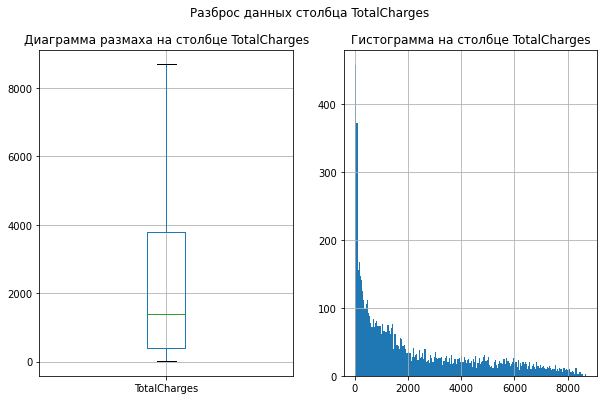

     --------------------------------------------------------------------------------------------------------


In [13]:
# Разброс данных
for column in ['MonthlyCharges', 'TotalCharges']:
    data_spread(contract, column)

In [14]:
# Посмотрим на уникальные значения категориальных признаков
uniqueness(contract, ['Type', 'PaperlessBilling', 'PaymentMethod'])

Количество уникальных значений столбца Type: 3
['Two year' 'Month-to-month' 'One year']
-----------------------------
Количество уникальных значений столбца PaperlessBilling: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца PaymentMethod: 4
['Bank transfer (automatic)' 'Mailed check' 'Electronic check'
 'Credit card (automatic)']
-----------------------------


#### DF personal

In [15]:
personal.head(1)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No


In [16]:
# Посмотрим на уникальные значения категориальных признаков. Непрерывных данных нет
uniqueness(personal, personal.columns.drop('customerID'))

Количество уникальных значений столбца gender: 2
['Female' 'Male']
-----------------------------
Количество уникальных значений столбца SeniorCitizen: 2
[0 1]
-----------------------------
Количество уникальных значений столбца Partner: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца Dependents: 2
['No' 'Yes']
-----------------------------


#### DF internet

In [17]:
internet.head(1)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
1,7590-VHVEG,DSL,No,Yes,No,No,No,No


In [18]:
# Посмотрим на уникальные значения категориальных признаков. Непрерывных данных нет
uniqueness(internet, internet.columns.drop('customerID'))

Количество уникальных значений столбца InternetService: 2
['DSL' 'Fiber optic']
-----------------------------
Количество уникальных значений столбца OnlineSecurity: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца OnlineBackup: 2
['Yes' 'No']
-----------------------------
Количество уникальных значений столбца DeviceProtection: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца TechSupport: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingTV: 2
['No' 'Yes']
-----------------------------
Количество уникальных значений столбца StreamingMovies: 2
['No' 'Yes']
-----------------------------


#### DF phone

In [19]:
phone.head(1)

,customerID,MultipleLines
1,5575-GNVDE,No


In [20]:
# Посмотрим на уникальные значения категориальных признаков. Непрерывных данных нет
uniqueness(phone, phone.columns.drop('customerID'))

Количество уникальных значений столбца MultipleLines: 2
['No' 'Yes']
-----------------------------


#### Объединение в один DF

In [21]:
data = personal.merge(contract, on ='customerID', how='inner')
data = data.merge(internet, on ='customerID', how = 'outer')
data = data.merge(phone, on ='customerID', how = 'outer')
data.name = 'data'
df_info(data)

Информация о DF data



,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Female,0,Yes,No,2019-04-29,None,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,Male,0,No,No,2019-03-26,None,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,Male,0,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,Male,0,No,No,2018-12-22,None,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,Female,0,No,No,2019-01-26,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,No
5,9305-CDSKC,Female,0,No,No,2018-12-26,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.50,Fiber optic,No,No,Yes,No,Yes,Yes,Yes
6,1452-KIOVK,Male,0,No,Yes,2018-12-20,None,Month-to-month,Yes,Credit card (automatic),89.10,1949.40,Fiber optic,No,Yes,No,No,Yes,No,Yes



<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 

,SeniorCitizen,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,0.162147,64.761692,2283.300441
std,0.368612,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,0.000000,35.500000,401.450000
50%,0.000000,70.350000,1397.475000
75%,0.000000,89.850000,3794.737500
max,1.000000,118.750000,8684.800000


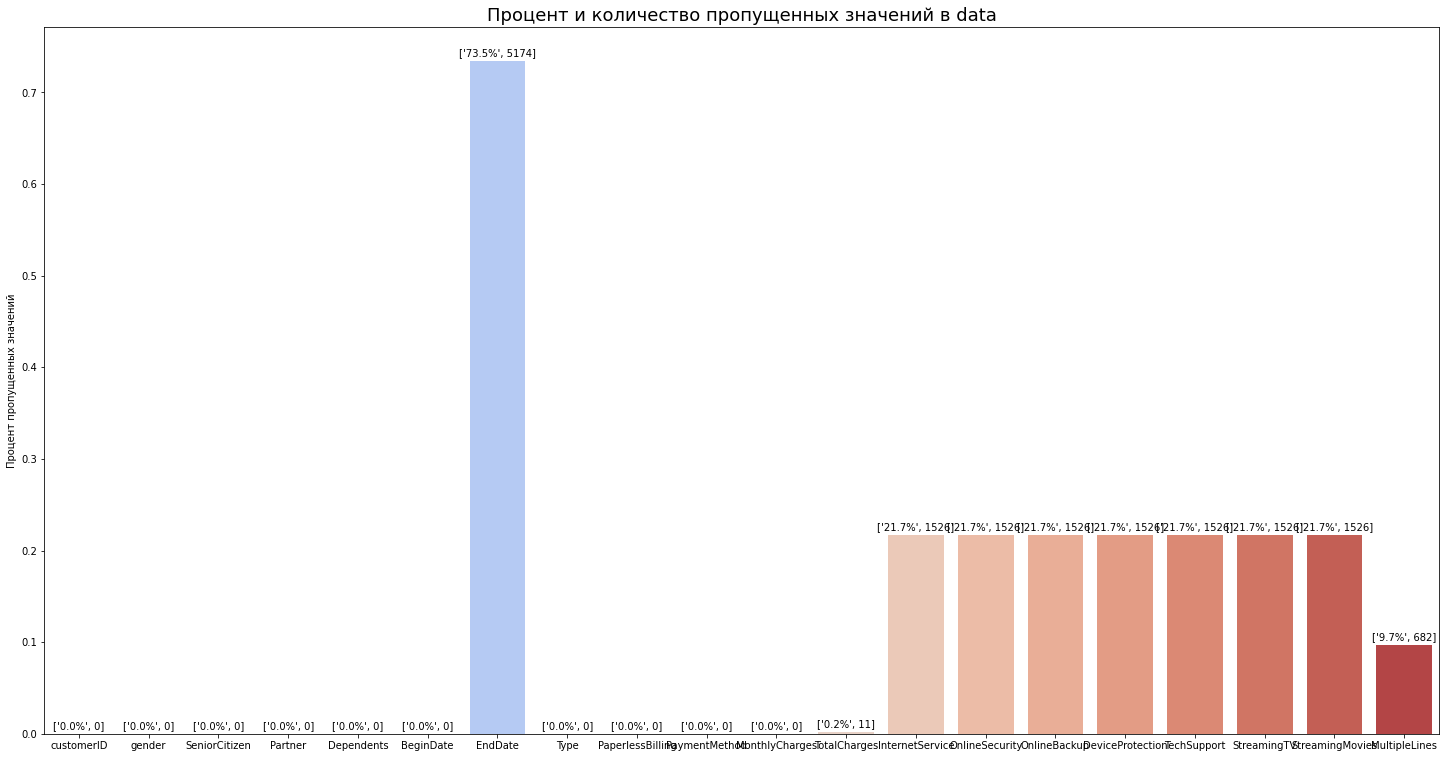

In [22]:
nan_plot(data)

### Вывод

В результате исследовательского анализа были рассмотрены все 4 таблицы:
- contract - единственная из представленных сущностей с непрерывными переменнами:
    - MonthlyCharges - имеет множество пиковых зон, видимо связанных с ежемесячным платежём, а разбросы рядом с ними - дополнительные затраты пользователей в месяц. Судя по boxplot, признак не имеет выбрасов, а медиана находится в районе значения 70, при этом данные в большинстве своём находятся в диапазоне от 35 до 90 условных единиц.
    - TotalCharges - имеет покозательное распределение в диапазоне (0, 8684], плавно убывающее в сторону положительного oX. В данных также отсутствуют выбросы, медиана распределена в районе 1600, а большинство значений находятся в диапазоне от 300 до 3700. Подобное распределение обусловленно накопительным свойством клиента - чем дольше он ходит с договором, тем больше суммарная цена затрат.
    Все остальные столбцы - категориальные, без неявных дубликатов;
- personal - только категориальные столбцы без неявных дубликатов. Однако стоит поменять SeniorCitizen с int на object для дальнейшей корректной работы;
- internet - только категориальные столбцы без неявных дубликатов;
- phone - Также категориальные столбцы без неявных дубликатов.

После объединения всех 4 сущностей в один DF у нас получилось 20 столбцов, и 7043 наблюдения. NaN значения будем убирать на следующем этапе - они появились из-за того, что не все пользователи пользуются и интернетом, и телефонной связью одновременно. Также стоит провести features engineering со столбцами datetime, тк свою полезность они маловероятно покажут на этапе предсказаний, и нам нужно будет их удалить.

## Предобработка данных

In [23]:
# Преобразуем столбец EndDate в нашу целевую переменную

def target_markeup(row):
    
    if row['EndDate'] is None:
        return 0
    return 1

data['target'] = data.progress_apply(target_markeup, axis=1)

100%|██████████| 7043/7043 [00:00<00:00, 87626.02it/s]


In [24]:
# Заполним NaN значения, которые появились при объединении сущностей
# WOI - без интернета, WOT - без телефонной связи

woi = ['MultipleLines']
wot = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

data[woi] = data[woi].fillna('WOI')
data[wot] = data[wot].fillna('WOT')

data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   BeginDate         7043 non-null   object 
 6   EndDate           1869 non-null   object 
 7   Type              7043 non-null   object 
 8   PaperlessBilling  7043 non-null   object 
 9   PaymentMethod     7043 non-null   object 
 10  MonthlyCharges    7043 non-null   float64
 11  TotalCharges      7032 non-null   float64
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [25]:
# Поменяем int на object в столбце SeniorCitizen

data.loc[data['SeniorCitizen'] == 0, 'SeniorCitizen'] = 'No'
data.loc[data['SeniorCitizen'] == 1, 'SeniorCitizen'] = 'Yes'

data.SeniorCitizen.unique()

array(['No', 'Yes'], dtype=object)

In [26]:
# Прежде чем удалить временные столбцы попробуем сгенерировать новые признаки

# Количество дней пользования тарифом. Если контракт не разорван - ограничиваемся дедлайном.
data['BeginDate'] = pd.to_datetime(data['BeginDate'])
data['EndDate'] = pd.to_datetime(data['EndDate'])
data['EndDate'] = data['EndDate'].fillna(pd.to_datetime('01-02-2020', format='%d-%m-%Y'))
data['use_days'] = (data['EndDate'] - data['BeginDate']).dt.days

data.head(3)

,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,use_days
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,2020-02-01,Month-to-month,Yes,Electronic check,...,DSL,No,Yes,No,No,No,No,WOI,0,278
1,5575-GNVDE,Male,No,No,No,2019-03-26,2020-02-01,One year,No,Mailed check,...,DSL,Yes,No,Yes,No,No,No,No,0,312
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,DSL,Yes,Yes,No,No,No,No,No,1,479


In [27]:
# Подсчитаем количество дней, которые остались до оплаты пользования за следующий период

def days_before_payment(row):
    if row['Type'] == 'Month-to-month':
        return row['use_days'] % 30
    elif row['Type'] == 'One year':
        return row['use_days'] % 366
    return row['use_days'] % 732

data['dbp'] = data.progress_apply(days_before_payment, axis=1)
data.head(3)

100%|██████████| 7043/7043 [00:00<00:00, 54569.49it/s]


,customerID,gender,SeniorCitizen,Partner,Dependents,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,...,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,use_days,dbp
0,7590-VHVEG,Female,No,Yes,No,2019-04-29,2020-02-01,Month-to-month,Yes,Electronic check,...,No,Yes,No,No,No,No,WOI,0,278,8
1,5575-GNVDE,Male,No,No,No,2019-03-26,2020-02-01,One year,No,Mailed check,...,Yes,No,Yes,No,No,No,No,0,312,312
2,3668-QPYBK,Male,No,No,No,2018-08-09,2019-12-01,Month-to-month,Yes,Mailed check,...,Yes,Yes,No,No,No,No,No,1,479,29


In [28]:
# Удалим столбецы времени, а также дропнем оставшиеся 11 NaN значений

del data['BeginDate']
del data['EndDate'] 
del data['customerID']

data.dropna(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7032 non-null   object 
 1   SeniorCitizen     7032 non-null   object 
 2   Partner           7032 non-null   object 
 3   Dependents        7032 non-null   object 
 4   Type              7032 non-null   object 
 5   PaperlessBilling  7032 non-null   object 
 6   PaymentMethod     7032 non-null   object 
 7   MonthlyCharges    7032 non-null   float64
 8   TotalCharges      7032 non-null   float64
 9   InternetService   7032 non-null   object 
 10  OnlineSecurity    7032 non-null   object 
 11  OnlineBackup      7032 non-null   object 
 12  DeviceProtection  7032 non-null   object 
 13  TechSupport       7032 non-null   object 
 14  StreamingTV       7032 non-null   object 
 15  StreamingMovies   7032 non-null   object 
 16  MultipleLines     7032 non-null   object 


In [29]:
# Посмотрим на дисбаланс классов
data['target'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: target, dtype: float64

### Вывод

По итогам предобработки данных мы лишились 0.2% данных - это люди, которые подписали договоры в последний день сбора данных. NaN значения, которые появились после объединения всех 4 таблиц мы заполнили следующим образом: WOI - без интернета, WOT - без телефонной связи. Также был добавлен target - обнаруен дисбаланс классов 74%/26%, что в дальнейшей работе будем исправлять весами модели (class_weight='balanced). Столбцы даты и времени были удалены вместе с ID клиента, вместо двух первых были добавлены новые, более информативные для обучения данные (показал в следующей главе):
- use_days - количество дней действия контракта
- dbp - количество дней до оплаты тарифа

## Исследовательский анализ данных

#### Для начала посмотрим как распределена наша целевая переменная внутри каждого признака

В данной работе я не буду пользоваться стандартной корреляцией, а перейду к более сильному "соседу" по двум причинам:
- Стандартная корреляция показывает лишь линейные зависимости. Это означает, что если данные зависят друг от друга, к примеру, $x^2$, то корреляция будет в районе 0, если не 0. Корреляция "Фи" умеет различать разные степени зависимостей, хоть и с бОльшим отклонением.
- У нас много категориальных переменных, что в свою очередь не сможет обработать data.corr(), в отличии от Phik, которая, опять же, умеет работать с подобными данными.

In [30]:
phik_overview = data.phik_matrix(interval_cols=['MonthlyCharges', 'TotalCharges', 'use_days', 'dbp'])
phik_overview.round(2)
print('Подготовили матрицу корреляции Phik')

/opt/conda/lib/python3.9/site-packages/phik/bivariate.py:85: DeprecationWarning: Please use `mvnun` from the `scipy.stats` namespace, the `scipy.stats.mvn` namespace is deprecated.
  return mvn.mvnun(lower, upper, mu, S)[0]


Подготовили матрицу корреляции Phik


In [31]:
def violentplot(df, column, target):
    plt.figure(figsize = (8, 5))
    sns.violinplot(
        x = target,
        y = column,
        data = df,
        kind = "violin",
        split = True,
        palette = "coolwarm"
    )
    plt.show()

    if df[column].nunique() <= 25:
        plt.figure(figsize = (12, 10))
        sns.histplot(data=df,
                     x=column,
                     binwidth=1,
                     hue=target)
        plt.show()

    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()

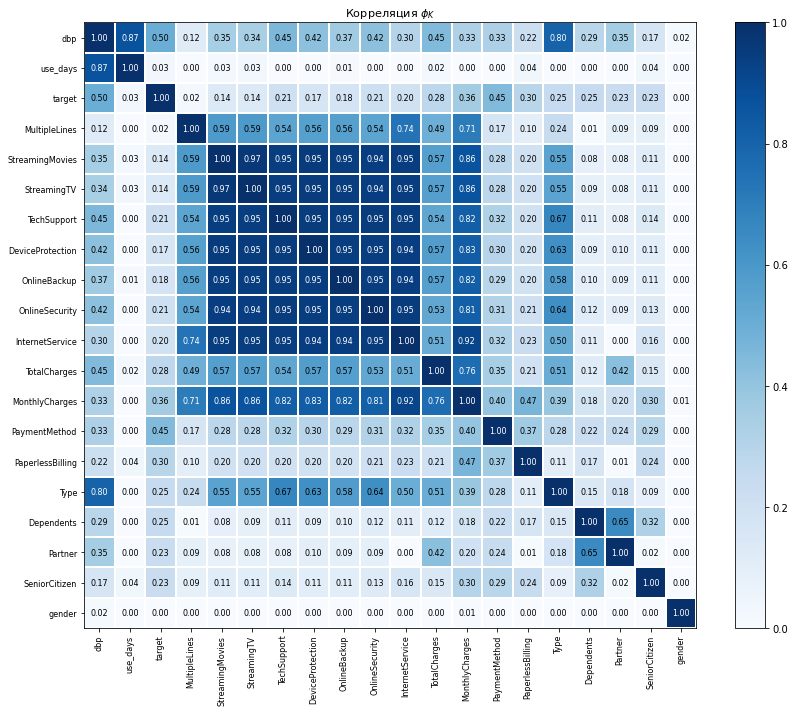

In [32]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="Blues", 
                        title=r"Корреляция $\phi_K$", 
                        fontsize_factor=0.8, 
                        figsize=(12, 10))
plt.tight_layout()
plt.show()

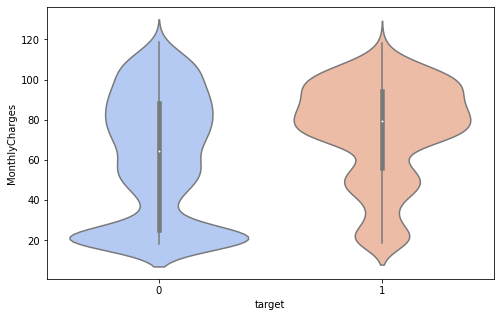


Корреляция Phik: 0.36
-----------------------------------------------------------------------------------------------



In [33]:
violentplot(data, 'MonthlyCharges', 'target')

Мы можем наблюдать, что клиент чаще всего уходит при больших ежемесячных затратах. Большинство людей, которые не разорвали договор с компанией платят 20 условных денежных едениц, но как только планка поднимается до 80 - шанс расторжения договора повышается. У данного признака слабая зависимость с нашей целевой переменной.

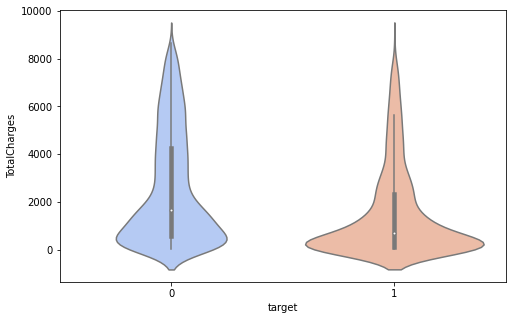


Корреляция Phik: 0.28
-----------------------------------------------------------------------------------------------



In [34]:
violentplot(data, 'TotalCharges', 'target')

Данная взаимосвязь может говорить о том, что человек уходит от компании буквально на первых этапах знакомства с тарифом. Необходимо уточнить самый частый фактор разрыва контракта у аналитиков, чтобы лучше понимать по какой причине это происходит. Также можно заметить, что "долгие контракты" чаще всего остаются в компании. Если тариф полностью покрывает необходимости клиента - он им пользуется на протяжении долгого времени. Наблюдается слабая зависимость равная 28%.

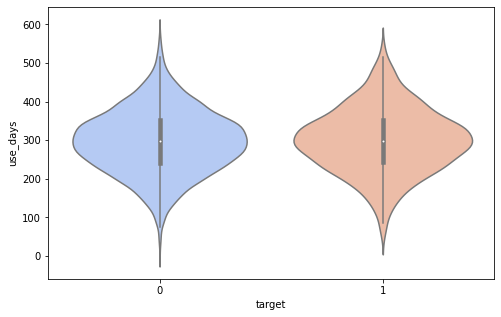


Корреляция Phik: 0.03
-----------------------------------------------------------------------------------------------



In [35]:
violentplot(data, 'use_days', 'target')

Данные нового добавленного столбца независимы между собой. Отказ.

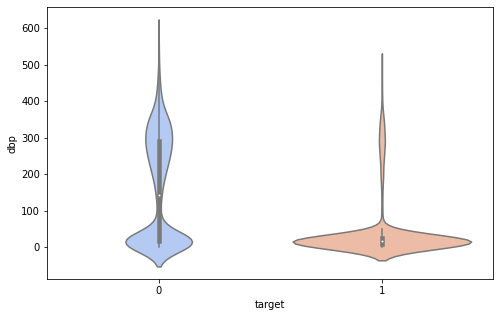


Корреляция Phik: 0.5
-----------------------------------------------------------------------------------------------



In [36]:
violentplot(data, 'dbp', 'target')

Признак dbp - количество дней, которые остались до оплаты следующего периода тарифа. Достаточно хороший показатель, который имеет умеренную зависимость. Пользователи чаще всего отказываются от тарифа в последние дни, что очевидно, но доказать нужно было.

In [37]:
def proba_plot(data, column):
    array0 = []
    array1 = []
    unique_list = list(data[column].unique())
    for i in range(len(unique_list)):
        all_unique = data.loc[data[column] == unique_list[i], column].count()

        target_1 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 1), column].count()
        proba1 = np.round((target_1 / all_unique), 2)
        target_0 = data.loc[(data[column] == unique_list[i]) & (data['target'] == 0), column].count()
        proba0 = np.round((target_0 / all_unique), 2)

        array0.append([unique_list[i], proba0, 'Не ушёл'])
        array1.append([unique_list[i], proba1, 'Ушёл'])

    array = np.concatenate([array0, array1], axis=0)
    df = pd.DataFrame(data=array, columns = ['Уникальные значения столбца '+column, 'Доля клиентов', 'Hue'])
    df['Доля клиентов'] = df['Доля клиентов'].astype(float) # Объясните пожалуйста почему после concatenate данные переходят с float на object. Пришлось переводить, ошибку нак и не понял...
    display(df)
    
    sns.barplot(data = df, x = 'Уникальные значения столбца '+column, y = 'Доля клиентов', hue = 'Hue')
    plt.show()
    
    print()
    print('Корреляция Phik:', np.round(phik_overview.loc[column]['target'], 2))
    print('-----------------------------------------------------------------------------------------------')
    print()
    
    return None

,Уникальные значения столбца gender,Доля клиентов,Hue
0,Female,0.73,Не ушёл
1,Male,0.74,Не ушёл
2,Female,0.27,Ушёл
3,Male,0.26,Ушёл


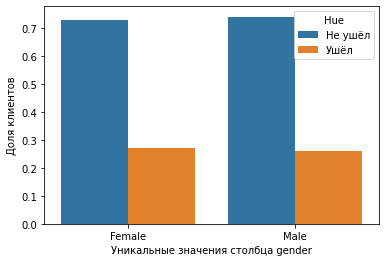


Корреляция Phik: 0.0
-----------------------------------------------------------------------------------------------



In [38]:
proba_plot(data, 'gender')

Признак пола независим с нашим таргетом. Отказ

,Уникальные значения столбца Type,Доля клиентов,Hue
0,Month-to-month,0.57,Не ушёл
1,One year,0.89,Не ушёл
2,Two year,0.97,Не ушёл
3,Month-to-month,0.43,Ушёл
4,One year,0.11,Ушёл
5,Two year,0.03,Ушёл


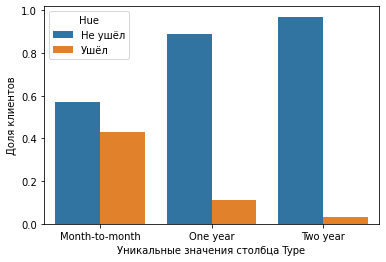


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------



In [39]:
proba_plot(data, 'Type')

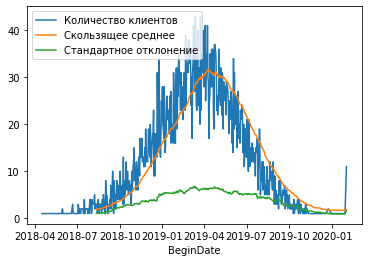

In [40]:
begin_pivot = contract.pivot_table(index='BeginDate', values='customerID', aggfunc='count')

begin_pivot['Скользящее среднее'] = begin_pivot['customerID'].rolling(50).mean()
begin_pivot['Стандартное отклонение'] = begin_pivot['customerID'].rolling(50).std()
begin_pivot.rename(columns={'customerID': 'Количество клиентов'}, inplace=True)
begin_pivot.plot()
plt.show()

Чаще всего контракт разрывают клиенты, которые платят за тариф раз в месяц. Логика просвечивается на данном признаке следующая: если человек будет платить раз в год-два, то с большей вероятностью он не будет разрывать контракт, тк уверен в своём выборе. Однако, скорее всего, здесь работает немного другая логика - пользователь чаще всего разрывает контракт на последних месяцах пользования, а в выборке самый "первый" клиент имеет временную метку datetime.date(2018, 4, 17), тогда я не могу утверждать даже на 50%, что данный признак является актуальным для нас, ведь пик подписания контрактов - май 2019 года, а информация о договорах актуальна на 1 февраля 2020. Нам придётся отказаться от данного признака, тк он не объективен для наших данных. При будущих предсказаниях в компании алгоритм может с бОльшей вероятностью выдавать класс 0, если человек платит раз в год-два, хотя это скорее всего не так. Отказ

,Уникальные значения столбца SeniorCitizen,Доля клиентов,Hue
0,No,0.76,Не ушёл
1,Yes,0.58,Не ушёл
2,No,0.24,Ушёл
3,Yes,0.42,Ушёл


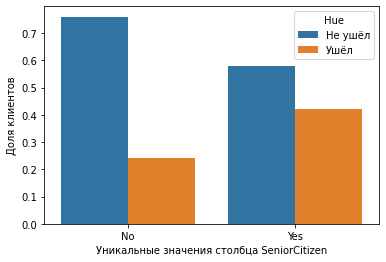


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



In [41]:
proba_plot(data, 'SeniorCitizen')

Пенсионеры чаще разрывают договоры, нежели остальные. Данный столбец имеет 23% слабую зависимость.

,Уникальные значения столбца Partner,Доля клиентов,Hue
0,Yes,0.80,Не ушёл
1,No,0.67,Не ушёл
2,Yes,0.20,Ушёл
3,No,0.33,Ушёл


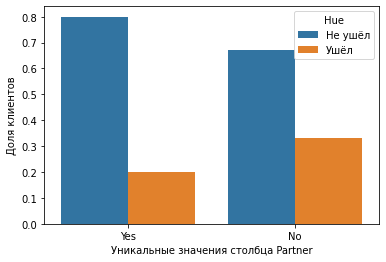


Корреляция Phik: 0.23
-----------------------------------------------------------------------------------------------



In [42]:
proba_plot(data, 'Partner')

Неженатые люди чаще всего уходят от компании. Возможно это связано с постоянными переездами или по каким-то другим причинам. Хоть и не сильно данных столбец отстаёт от женатых (класс 1), тем неменее мы имеет слабую зависимость равную 23%.

,Уникальные значения столбца Dependents,Доля клиентов,Hue
0,No,0.69,Не ушёл
1,Yes,0.84,Не ушёл
2,No,0.31,Ушёл
3,Yes,0.16,Ушёл


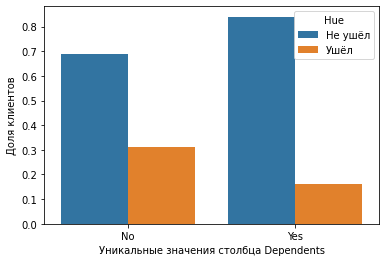


Корреляция Phik: 0.25
-----------------------------------------------------------------------------------------------



In [43]:
proba_plot(data, 'Dependents')

Чааще всего люди с детьми разрывают договор с компанией. Мы имеет слабую зависимость в 25%

,Уникальные значения столбца PaperlessBilling,Доля клиентов,Hue
0,Yes,0.66,Не ушёл
1,No,0.84,Не ушёл
2,Yes,0.34,Ушёл
3,No,0.16,Ушёл


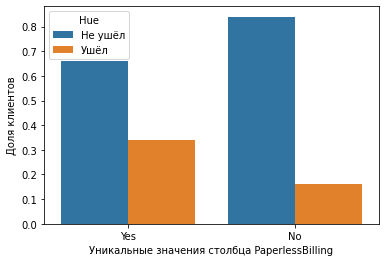


Корреляция Phik: 0.3
-----------------------------------------------------------------------------------------------



In [44]:
proba_plot(data, 'PaperlessBilling')

,Уникальные значения столбца PaymentMethod,Доля клиентов,Hue
0,Electronic check,0.55,Не ушёл
1,Mailed check,0.81,Не ушёл
2,Bank transfer (automatic),0.83,Не ушёл
3,Credit card (automatic),0.85,Не ушёл
4,Electronic check,0.45,Ушёл
5,Mailed check,0.19,Ушёл
6,Bank transfer (automatic),0.17,Ушёл
7,Credit card (automatic),0.15,Ушёл


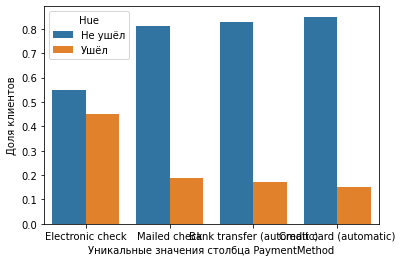


Корреляция Phik: 0.45
-----------------------------------------------------------------------------------------------



In [45]:
proba_plot(data, 'PaymentMethod')

Клиенты, которые пользуются любым видом автоплатежа из представленных с меньшей вероятностью разорвут договор с компанией, в отличии от тех, кто пользуется электронным чеком. Возможно это связано с забывчивастью клиента, возможно наоборот - с его уверенностью в тарифе.

,Уникальные значения столбца InternetService,Доля клиентов,Hue
0,DSL,0.81,Не ушёл
1,Fiber optic,0.58,Не ушёл
2,WOT,0.93,Не ушёл
3,DSL,0.19,Ушёл
4,Fiber optic,0.42,Ушёл
5,WOT,0.07,Ушёл


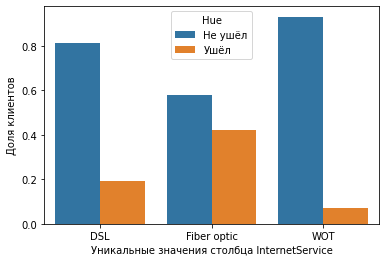


Корреляция Phik: 0.2
-----------------------------------------------------------------------------------------------



In [46]:
proba_plot(data, 'InternetService')

Мы можем наблюдать слабую корреляцию между признаком InternetService и нашей целевой переменой, однако люди, которые выбираеют оптоволокно чаще всего отказываются от услуг компании. Возможно причина кроется в его скорости или неудобствах, эту задачу нужно поставить аналитикам.

,Уникальные значения столбца OnlineSecurity,Доля клиентов,Hue
0,No,0.58,Не ушёл
1,Yes,0.85,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.42,Ушёл
4,Yes,0.15,Ушёл
5,WOT,0.07,Ушёл


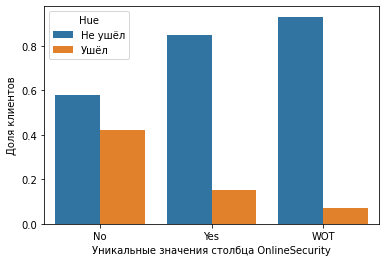


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



In [47]:
proba_plot(data, 'OnlineSecurity')

Доля клиентов без блокировки опасных сайтов, которые отказались от услуг провайдера превышет обратную. Зависимость равна 21 %

,Уникальные значения столбца OnlineBackup,Доля клиентов,Hue
0,Yes,0.78,Не ушёл
1,No,0.60,Не ушёл
2,WOT,0.93,Не ушёл
3,Yes,0.22,Ушёл
4,No,0.40,Ушёл
5,WOT,0.07,Ушёл


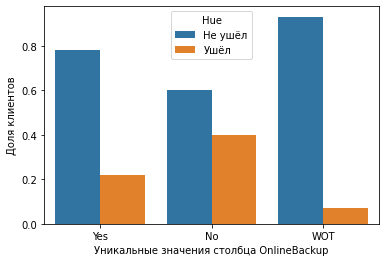


Корреляция Phik: 0.18
-----------------------------------------------------------------------------------------------



In [48]:
proba_plot(data, 'OnlineBackup')

Клиенты, которые пользуются облачными хранилищами файлов для резервного копирования данных реже разрывают контракт, нежели те, кто не пользуются. Наблюдается слабая зависимость равная 18%.

,Уникальные значения столбца DeviceProtection,Доля клиентов,Hue
0,No,0.61,Не ушёл
1,Yes,0.77,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.39,Ушёл
4,Yes,0.23,Ушёл
5,WOT,0.07,Ушёл


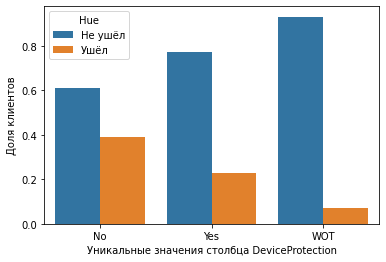


Корреляция Phik: 0.17
-----------------------------------------------------------------------------------------------



In [49]:
proba_plot(data, 'DeviceProtection')

Схожая картина с признаком Online Security наблюдается на Device Protection. Слабая зависимость в 17%.

,Уникальные значения столбца TechSupport,Доля клиентов,Hue
0,No,0.58,Не ушёл
1,Yes,0.85,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.42,Ушёл
4,Yes,0.15,Ушёл
5,WOT,0.07,Ушёл


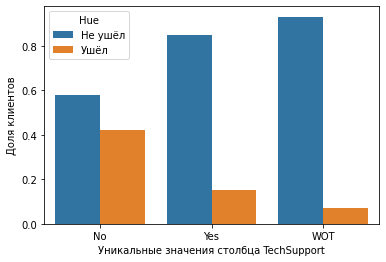


Корреляция Phik: 0.21
-----------------------------------------------------------------------------------------------



In [50]:
proba_plot(data, 'TechSupport')

Люди без выделенной линии технической поддержки чаще всего уходят из компании. Возможно это связано с неудобством, которые возникают во время возникновения проблем: большие задержки по ответам или постоянные переводы оператора. Наблюдается слабая зависимость равная 21%

,Уникальные значения столбца StreamingTV,Доля клиентов,Hue
0,No,0.66,Не ушёл
1,Yes,0.70,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.34,Ушёл
4,Yes,0.30,Ушёл
5,WOT,0.07,Ушёл


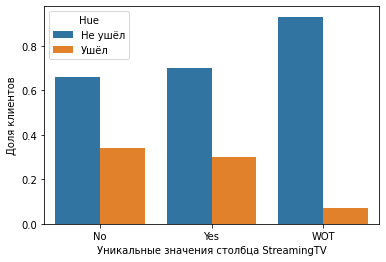


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------



In [51]:
proba_plot(data, 'StreamingTV')

Судя по графику данные независимы между собой. Отказ

,Уникальные значения столбца StreamingMovies,Доля клиентов,Hue
0,No,0.66,Не ушёл
1,Yes,0.70,Не ушёл
2,WOT,0.93,Не ушёл
3,No,0.34,Ушёл
4,Yes,0.30,Ушёл
5,WOT,0.07,Ушёл


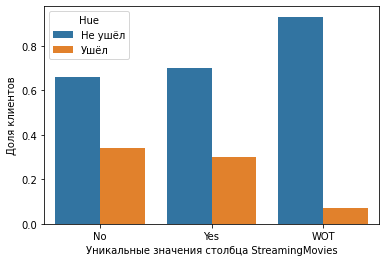


Корреляция Phik: 0.14
-----------------------------------------------------------------------------------------------



In [52]:
proba_plot(data, 'StreamingMovies')

Судя по графику данные независимы между собой. Отказ

,Уникальные значения столбца MultipleLines,Доля клиентов,Hue
0,WOI,0.75,Не ушёл
1,No,0.75,Не ушёл
2,Yes,0.71,Не ушёл
3,WOI,0.25,Ушёл
4,No,0.25,Ушёл
5,Yes,0.29,Ушёл


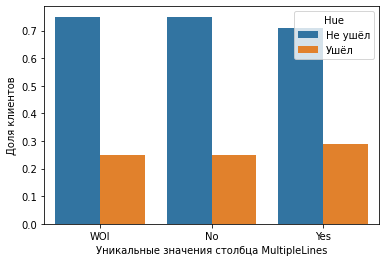


Корреляция Phik: 0.02
-----------------------------------------------------------------------------------------------



In [53]:
proba_plot(data, 'MultipleLines')

Признак подключения телефона к нескольким линиям одновременно независим с нашим таргетом. Отказ

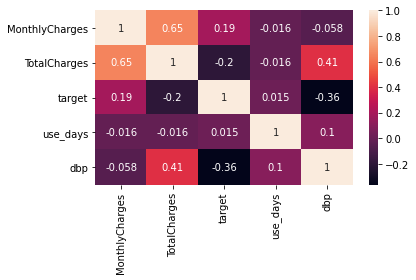

In [54]:
# Визуализируем матрицу корреляции
sns.heatmap(data.corr(), annot=True)
plt.tight_layout()
plt.show()

Судя по матрице, мультикорреляция не обнаружена среди непрерывных переменных. Смотрим по data.corr(), тк мультикорреляция - связана только с линейными зависимости, а Phik может выдать 1 при $X^2$, в корне неправильно будет их удалять. Тем более проблема мультикорреляции возникает только у линейных моделях, однако проверить стоит, тк могу забыть в конечном итоге исправить при необходимости.

In [55]:
#'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'
for column in ['use_days', 'gender', 'Type']:
    del data[column]

"#'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies'\nfor column in ['use_days', 'gender', 'Type']:\n    del data[column]\n    \ndf_info(data)"

Проверим наши признаки с помощью встроенных методов (embedded methods) на основе случайного леса. Пытался сделать исчерпывающий выбор признаков, однако так и не дождался результата (~18 часов). Закодируем данные простым LabelEncoder, чтобы деревянные модели смогли с ними работать.

In [56]:
X = data.drop('target', axis=1)
y = data['target']

label_encoder = LabelEncoder()
to_encode = ['SeniorCitizen', 'Partner', 'Dependents', 'PaperlessBilling', 'PaymentMethod', 'TechSupport', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'Type', 'gender']
for column in to_encode:
    X[column] = label_encoder.fit_transform(X[column])
    
X.head(3)

,gender,SeniorCitizen,Partner,Dependents,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,use_days,dbp
0,0,0,1,0,0,1,2,29.85,29.85,0,0,2,0,0,0,0,1,278,8
1,1,0,0,0,1,0,3,56.95,1889.50,0,2,0,2,0,0,0,0,312,312
2,1,0,0,0,0,1,3,53.85,108.15,0,2,2,0,0,0,0,0,479,29


,Importances
Features,
dbp,0.168656
TotalCharges,0.159402
MonthlyCharges,0.135939
use_days,0.111677
Type,0.086364
OnlineSecurity,0.044845
TechSupport,0.041681
PaymentMethod,0.041366
InternetService,0.029214


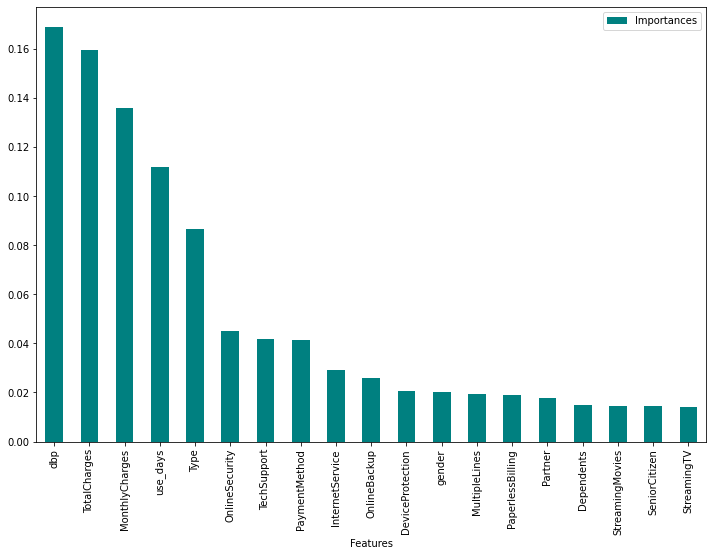

In [57]:
# создаем случайное дерево с нашими гипер параметрами
model = RandomForestClassifier(n_estimators=340, class_weight = 'balanced').fit(X, y)
importances = model.feature_importances_

final_df = pd.DataFrame({'Features' : pd.DataFrame(X).columns, 'Importances' : importances})
final_df.set_index('Features', inplace=True)

# Сортируем их по возрастанию для лучшей визуализации
final_df.sort_values(by='Importances', ascending=False, inplace=True)

# Выводим на график
final_df.plot.bar(color = 'teal', figsize=(12, 8));

display(final_df)

Безусловно у нас есть слабые параметры, однако убирать все мы не будем - дадут хоть небольшую прибавку к процентам при обучении.

### Вывод

По итогам исследовательского анализа были удалены несколько столбцов:
- use_days - количество дней пользования. Не дал весомой информации - данные некоррелируют с нашим target
- gender - доли людей, покинувших/не покинувших компанию были равными - данные не приносят никакой информации
- Type - необъективный признак, тк все наши клиенты в большинстве своём начали сотрудничать с компанией менее года назад.

Мы имеет 3 сильных признака непрерывных переменных, которые не имеют мультикорреляцию. Остальные оставим - они необходимы для прироста информации.

## Выбор модели

In [127]:
# Подготовим наши данные

#features = data[list(final_df['Importances'].head(12).index)] # Пробовал - стало хуже
features = data.drop('target', axis=1)
target = data['target']

In [132]:
# Разобьём на выборки

features_train, features_test, target_train, target_test = train_test_split(features, target,
                                                                            test_size = .25,
                                                                            random_state = RANDOM_STATE)


print(features_train.shape, target_train.shape,
      features_test.shape, target_test.shape)

(5625, 19) (5625,) (1407, 19) (1407,)


In [133]:
from sklearn.compose import ColumnTransformer

numerics = list(features.select_dtypes(include=['int64', 'float64']).columns)
categorical = list(features.select_dtypes(include='object').columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(features_train)
features_train = col_transformer.transform(features_train)
features_test = col_transformer.transform(features_test)

In [61]:
names = ['features_train', 'features_test']
ds = [features_train, features_test]
for i in range(len(ds)):
    print('-'*50)
    print(f'Размернсть {names[i]}:', ds[i].shape)
    print()

--------------------------------------------------
Размернсть features_train: (5625, 30)

--------------------------------------------------
Размернсть features_test: (1407, 30)



Я понимаю, что данные представлены вовсе не в нормальном распределении и в силу столь строгих допущений относительно данных наивные байесовские классификаторы обычно работают хуже, чем более сложные модели. Тем не менее у них есть несколько достоинств:

- они выполняют как обучение, так и предсказание исключительно быстро;
- обеспечивают простое вероятностное предсказание;
- их результаты часто очень легки для интерпретации;
- у них очень мало (если вообще есть) настраиваемых параметров.

Эти достоинства означают, что наивный байесовский классификатор зачастую оказывается удачным кандидатом на роль **первоначальной эталонной классификации**. Также в отличии от лоистической регресс (поэтому и не взял) она более менее справляется с категориальными признаками.

Существует несколько алгоритмов машинного обучения, которые хорошо работают с категориальными признаками и решают задачу бинарной классификации:

1. Деревья решений. Они могут обрабатывать категориальные признаки напрямую без необходимости преобразования в числовой формат.

2. Случайный лес. Он также может обрабатывать категориальные признаки напрямую и работает хорошо с данными, в которых есть множество признаков.

3. Бустинг. Такой метод машинного обучения может работать с категориальными признаками, если в модель подаются решающие деревья.

4. Нейронные сети. Они могут обрабатывать категориальные признаки с помощью кодирования "one-hot".

Как мне кажется, дерево решений справится с этой задачей хуже, поэтому обойдёмся без него. Также хочется заранее сказать, что я не буду смотреть только на ROC-AUC, в данной задаче нам важна точность попаданий в класс 1. Precision (точность) - это доля правильно классифицированных объектов положительного класса относительно всех объектов, которые классификатор предсказал как положительные. Метрика Precision показывает, насколько точными оказались наши предсказания классификатора. Иными словами, это мера того, сколько объектов, которые на самом деле относятся к положительному классу, было правильно определено. Другими словами, данную метрику можно использовать, когда нам не важны ошибки "непопадания" по классу 1 (когда предсказали класс 1, а на самом деле - 0), ничего страшного не случиться, если мы постараемся удержать клиента, который от нас не собирается уходить - важнее обноружить все 1.

In [62]:
analitics = pd.DataFrame(columns = ['ROC_AUC', 'Precision'])

def alter_table(name, roc_auc, precision):
    analitics.loc[name, ['ROC_AUC']] = roc_auc
    analitics.loc[name, ['Precision']] = precision
    return analitics

In [63]:
param_grid = {'var_smoothing': np.logspace(0,-9, num=100)}

gnb = GridSearchCV(GaussianNB(), param_grid=param_grid, cv=3, scoring=['roc_auc', 'precision'], refit = 'roc_auc').fit(features_train, target_train)
best_gnb = gnb.best_estimator_

In [64]:
cv_results = pd.DataFrame.from_dict(gnb.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('GaussianNB', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
GaussianNB,0.8223,0.4689


##### Случайный лес

In [65]:
grid_params = {
    'n_estimators': np.arange(40, 100, 10),
    'max_depth' : np.arange(12, 24)
}

grid_rf = GridSearchCV(RandomForestClassifier(), grid_params, cv=3, scoring=['roc_auc', 'precision'], refit = 'roc_auc').fit(features_train, target_train)
best_rf = grid_rf.best_estimator_

In [66]:
cv_results = pd.DataFrame.from_dict(grid_rf.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('RandomForestClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
GaussianNB,0.8223,0.4689
RandomForestClassifier,0.8334,0.6586


##### CatBoost

In [67]:
'''from sklearn.utils.class_weight import compute_class_weight

classes = np.unique(target_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)
class_weights = dict(zip(classes, weights))

print(class_weights)'''

"from sklearn.utils.class_weight import compute_class_weight\n\nclasses = np.unique(target_train)\nweights = compute_class_weight(class_weight='balanced', classes=classes, y=target_train)\nclass_weights = dict(zip(classes, weights))\n\nprint(class_weights)"

In [68]:
model_cbr = CatBoostClassifier(logging_level='Silent', loss_function='Logloss')
parameters_cbr = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1],
                  'iterations': [500,1000,1500,2000]}
catboost_grid = GridSearchCV(model_cbr,
                             parameters_cbr,
                             cv=3,
                             scoring=['roc_auc', 'precision'],
                             refit = 'roc_auc').fit(features_train, target_train)

In [69]:
cv_results = pd.DataFrame.from_dict(catboost_grid.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('CatBoostClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
GaussianNB,0.8223,0.4689
RandomForestClassifier,0.8334,0.6586
CatBoostClassifier,0.847,0.6879


##### LGBM

In [70]:
model_lgbm = LGBMClassifier()
parameters_lgbm = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.0001, 0.001, 0.01, 0.1, 1]}
lgbm = GridSearchCV(model_lgbm, 
                            parameters_lgbm, 
                            cv = 3,
                            scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, average='binary', zero_division=1)},
                            refit = 'roc_auc').fit(features_train, target_train)

In [71]:
cv_results = pd.DataFrame.from_dict(lgbm.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('LGBMClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
GaussianNB,0.8223,0.4689
RandomForestClassifier,0.8334,0.6586
CatBoostClassifier,0.847,0.6879
LGBMClassifier,0.8394,0.6522


##### XGBoost

In [90]:
model_xgb = xgboost.XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='error')
parameters_xgb = {'max_depth':np.arange(8, 16), 'eta':np.arange(0.1,1,0.1)}
GSCV_xgb = GridSearchCV(model_xgb, 
                    parameters_xgb, 
                    cv = 3,
                    scoring={'roc_auc': 'roc_auc', 'precision': make_scorer(precision_score, average='binary', zero_division=1)},
                    refit = 'roc_auc').fit(features_train, target_train)

In [91]:
cv_results = pd.DataFrame.from_dict(GSCV_xgb.cv_results_)
best_idx = cv_results.sort_values(by='rank_test_roc_auc').head(1).index[0]
roc = cv_results.loc[best_idx, 'mean_test_roc_auc']
pr = cv_results.loc[best_idx, 'mean_test_precision']

alter_table('XGBClassifier', round(roc, 4), round(pr, 4))

,ROC_AUC,Precision
GaussianNB,0.8223,0.4689
RandomForestClassifier,0.8334,0.6586
CatBoostClassifier,0.847,0.6879
LGBMClassifier,0.8394,0.6522
XGBClassifier,0.8245,0.6203


##### Полносвязная нейросеть

In [74]:
class CustomEarlyStopping():
    """
    Ранняя остановка, чтобы остановить тренировку, когда потеря не улучшается после определенной эпохи.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться, когда потеря не улучшается
        :param min_delta: минимальная разница между loss/метриками, если улучшений нет, то остановим обучение
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            # reset counter if validation loss improves
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:
            self.counter += 1
            print(f"INFO: Early stopping counter {self.counter} of {self.patience}")
            if self.counter >= self.patience:
                print('INFO: Early stopping')
                self.early_stop = True

In [75]:
# Переведём выборки в тензоры
X_train = torch.FloatTensor(np.array(features_train))
X_test = torch.FloatTensor(np.array(features_test))
y_train = torch.FloatTensor(np.array(target_train))
y_test = torch.FloatTensor(np.array(target_test))

In [76]:
class Net(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons):
            super(Net, self).__init__()
            
            self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1)
            self.bn1 = nn.BatchNorm1d(n_hidden_neurons_1)
            self.act1 = nn.ReLU()
            self.dp2 = nn.Dropout(p=0.2)
            self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2)
            self.act2 = nn.ReLU()
            self.fc3 = nn.Linear(n_hidden_neurons_2, n_out_neurons)
            self.act3 = nn.Sigmoid()
            
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.act1(x)
        x = self.dp2(x)
        x = self.fc2(x)
        x = self.act2(x)
        x = self.fc3(x)
        x = self.act3(x)
        
        return x

In [77]:
n_in_neurons = X_train.shape[1]
n_hidden_neurons_1 = 24
n_hidden_neurons_2 = 10
n_out_neurons = 1

net = Net(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_out_neurons)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)
loss = nn.BCEWithLogitsLoss()

In [78]:
dataset_train = torch.utils.data.TensorDataset(X_train, y_train)
dataset_test = torch.utils.data.TensorDataset(X_test, y_test)

train_dataloader = DataLoader(dataset_train, batch_size=40, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=40, num_workers=0)   

In [79]:
early_stopping = CustomEarlyStopping(patience=5, min_delta=20)

num_epochs = 100001
for epoch in range(num_epochs):
    net.train()
    for batch in train_dataloader:
        data_train, temperature_train = batch # просто выгружаем данные 
        optimizer.zero_grad()

        preds = net.forward(data_train).flatten()

        loss_value = loss(preds, temperature_train)
        loss_value.backward()
        optimizer.step()

    if epoch % 5 == 0:
        predicted_temp = [] 
        with torch.no_grad():
            net.eval()
            for batch in test_dataloader:
                data_test, temperature_test = batch # просто выгружаем данные

                test_preds = net.forward(data_test).flatten()
                predicted_temp.append(test_preds)
                BCE_loss = loss(test_preds, temperature_test)

        predicted_temp = torch.cat(predicted_temp).detach().numpy()
        ROC_AUC = roc_auc_score(y_test, predicted_temp)
        early_stopping(BCE_loss)
        if early_stopping.counter == 0:
            best_roc = ROC_AUC
            best_predicted_temp = predicted_temp
        print(f"epoch:{epoch}, ROC_AUC test: {ROC_AUC}")

        if early_stopping.early_stop:
            print('Early Stoppning!!!')
            print(f'Best ROC_AUC test {best_roc}')
            break 

epoch:0, ROC_AUC test: 0.8124609234869061
INFO: Early stopping counter 1 of 5
epoch:5, ROC_AUC test: 0.8070670834828062
INFO: Early stopping counter 2 of 5
epoch:10, ROC_AUC test: 0.794657407881925
INFO: Early stopping counter 3 of 5
epoch:15, ROC_AUC test: 0.8030646235842771
INFO: Early stopping counter 4 of 5
epoch:20, ROC_AUC test: 0.7960615999590017
INFO: Early stopping counter 5 of 5
INFO: Early stopping
epoch:25, ROC_AUC test: 0.8059268180187568
Early Stoppning!!!
Best ROC_AUC test 0.8124609234869061


Нейросеть показала слабый результат по сравнению с другими моделями, его в таблицу не будем включать

,ROC_AUC,Precision
CatBoostClassifier,0.847,0.6879
LGBMClassifier,0.8394,0.6522
RandomForestClassifier,0.8334,0.6586
XGBClassifier,0.8245,0.6203
GaussianNB,0.8223,0.4689


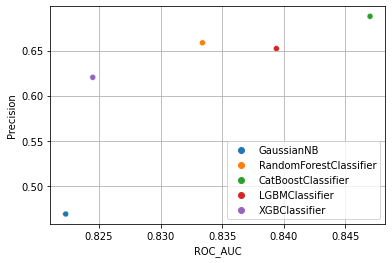

In [80]:
# Визуализируем результаты

display(analitics.sort_values(by=['ROC_AUC', 'Precision'], ascending=False))

sns.scatterplot(data=analitics, x = 'ROC_AUC', y = 'Precision', hue=list(analitics.index))
plt.grid(True)
plt.show()

### Вывод

Без сомнения CatBoost выиграла "гонку" за метрику и в дальнейшем для теста мы будем использовать именно её. Также она показала средний, судя по всем моделям, результат на метрике Precision равный ~69%, AUC-ROC - 84.7%.

## Тестирование модели

In [81]:
catboost_grid.best_params_

{'iterations': 500, 'learning_rate': 0.01, 'max_depth': 5}

In [82]:
model = CatBoostClassifier(logging_level='Silent',
                           loss_function='Logloss',
                           iterations = 500, 
                           learning_rate = 0.01, 
                           max_depth = 5).fit(features_train, target_train)
predictions = model.predict(features_test)

In [83]:
y_pred_proba = model.predict_proba(features_test)[:, 1]

# Вычисляем AUC-ROC на тестовом наборе данных
auc_roc = roc_auc_score(target_test, y_pred_proba)
print('AUC-ROC на тестовом наборе данных:', round(auc_roc, 2))

AUC-ROC на тестовом наборе данных: 0.85


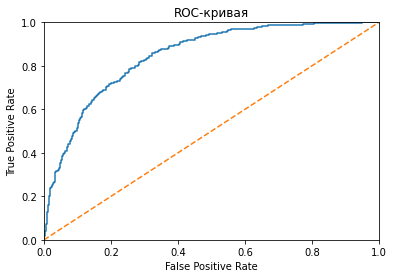

In [84]:
predicted_probalities = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, predicted_probalities)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

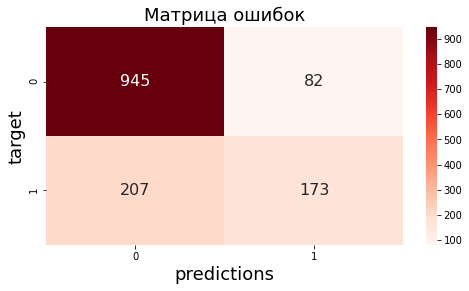

In [85]:
# Создадим матрицу ошибок CBC
cm_cbc = confusion_matrix(target_test, predictions)
cm_cbc_data = pd.DataFrame(cm_cbc,
                           index=['0', '1'],
                           columns=['0', '1'])

plt.figure(figsize=(8, 4))
sns.heatmap(cm_cbc, xticklabels=cm_cbc_data.columns, yticklabels=cm_cbc_data.index, annot=True, fmt='g', cmap="Reds", annot_kws={"size": 16})
plt.title("Матрица ошибок", size=18)
plt.xlabel('predictions', size=18)
plt.ylabel('target', size=18);

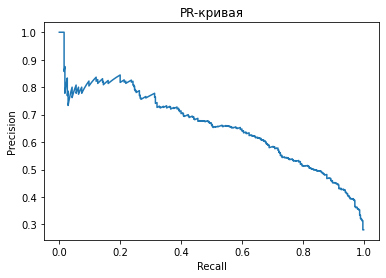

In [86]:
from sklearn.metrics import precision_recall_curve

# Получаем точность, полноту и соответствующие пороги 
precision, recall, threshold = precision_recall_curve(target_test, y_pred_proba)

# Строим PR-кривую
plt.plot(recall, precision)

# Добавляем подписи осей и заголовок графика
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR-кривая')

plt.show()


,importance
feature,
dbp,20.161598
TotalCharges,19.988348
InternetService_Fiber optic,10.626137
MonthlyCharges,7.790469
Type_Two year,4.790338
use_days,3.529603
TechSupport_Yes,3.332311
PaperlessBilling_Yes,3.316695
PaymentMethod_Electronic check,2.953978


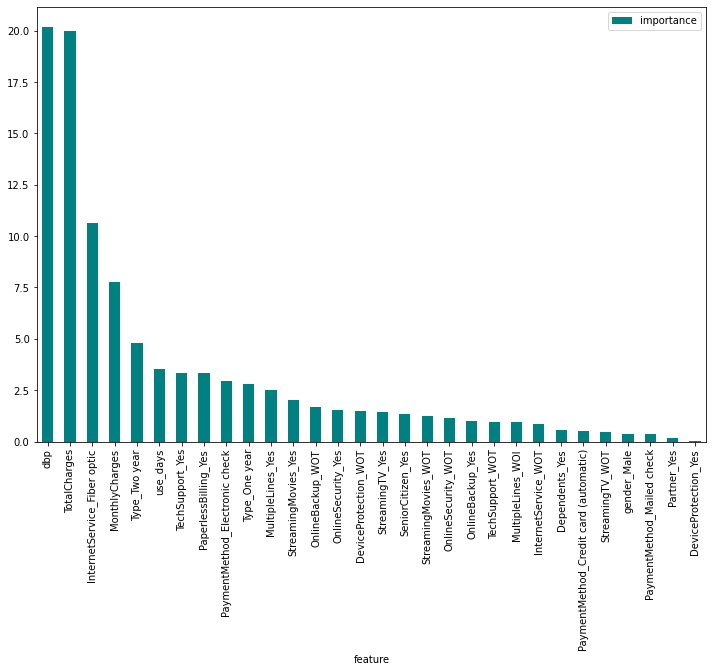

In [139]:
# исследуем важность признаков у ЛУЧШЕЙ модели

feature_names_numeric = numerics
feature_names_categorical = col_transformer.named_transformers_['ohe'].get_feature_names(categorical)
feature_names = feature_names_numeric + list(feature_names_categorical)

feature_importances = model.feature_importances_

# Сохранение результатов в DataFrame
fi_df = pd.DataFrame({'feature': feature_names,
                   'importance': feature_importances}) \
                    .sort_values('importance', ascending = False)

# Вывод важности признаков
fi_df.set_index('feature', inplace=True)
display(fi_df.head(10))

fi_df.plot.bar(color = 'teal', figsize=(12, 8));

In [ ]:
violentplot(data, 'dbp', 'target')

Самый весомы показатель для нашей модели - наш сгенерированный признак dbp (количество дней до оплаты следующего периода). Как мы можем видеть на графике зависимости люди чаще всего расторгают договор с компанией за несколько дней до продления периода. Именно в данный момент необходимо выдавать купоны на скидку - это может поднять интерес клиента.

## Вывод

Бустинг модель CatBoostClassifier очень хорошо показала себя на тестовых данных. По итогам предсказаний мы имеем AUC-ROC 0.82.

Если обратиться к матрице ошибок, то можно увидеть, что наша модель на 40% чаще ошибается с 1 (предсказывает 0), нежели с 1 (предсказывает 0). С точки зрения бизнеса - это не особо хороший показатель, тк в нашем случае не так страшно получить ошибку первого рода, нежели второго. По итогам мы имеем:
- 65% от общего количества тестовых данных - правильное определение класса 0
- 14% - правильное предсказание коасса 1
- 8% мы неправильно угадываем класс 0, метка предсказания - 1
- 13% мы неправильно идентефицируем человека, который не хочет уйти, хотя скоро разорвёт договор на окозание услуг

Хочется добавить, что возможно развить показатели данной модели на более высокий уровень:
- Необходимо добавить данные, более длительный дедлайн по сбору. Собрать как можно больше информации, возможно, сгенерировать её и поставить на обработку искуственные наблюдения.
- Обогатить имеющиеся сущности в базе данных. Возможно, стоит добавить таблицу, в которой будет информация об использовании тарифа каждым клиентом - это позволит не только более гибко сделать feature engineering + selection, но и проанализировать сложившуюся ситуацию в компании. Возможно это даст новый толчок маркетологам, аналитикам и инжинерам. Также стоит провести опрос, когда человек разрывает договор, что позволит, хоть и в минимальных объёмах, увидеть слабые стороны компании. 